# MLA 703. RNN-LSTM et architectures avancées [Analyse de sentiment]

In [1]:
# Dans ce notebook, nous allons nous intéresser à des tâches d'analyse de sentiments
# -> c'est à dire prédire un label de sentiment (ici positif ou négatif) à partir d'un texte

# Ce notebook vise à approfondir : 
# - L'application du DL sur des données textuelles
# - La compréhension des architectures RNN avancées comme les LSTM et les mécanismes d'attention
#

# Importation des modules

In [2]:
# On importe les librairies usuelless
import math
import numpy as np
import matplotlib.pyplot as plt

# On désactive les warnings
import warnings
warnings.filterwarnings('ignore')


# Fonction utile 

In [3]:
def plot_history(history):
    # On trace la loss et l'accuracy du modèle
    # On trace l'évolution de l'accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy']) 
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # On trace l'évolution de la loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [4]:
def predict(model):

    # On prédit sur l'ensemble de test

    # On prédit sur les données de test
    y_hat = model.predict(x_test)

    # On tranforme les prédictions en labels
    i_pos = [i for i in range(len(y_hat)) if y_hat[i]>0]
    i_neg = [i for i in range(len(y_hat)) if y_hat[i]<=0]

    y_pred   = np.zeros(len(y_hat))
    y_pred[i_pos] = 1
    y_pred[i_neg] = 0
    return y_pred

## 1. Charger les données

In [5]:
# On charge directement la base IMDB par les datasets de Keras
# La méthode load_date possède pas mal d'options et de propriétés intéressantes (voir description) :
# 1) Sépare les jeux d'entrainement et de test
# 2) num_words : Top most frequent words to consider.
# 3) skip_top : Top most frequent words to ignore (they will appear as oov_char value in the sequence data).
# 4) maxlen : Maximum sequence length. Any longer sequence will be truncated.
# 5) seed : Seed for reproducible data shuffling.
# 6) start_char : The start of a sequence will be marked with this character. Set to 1 because 0 is usually the
#    padding character.
# 7) oov_char : words that were cut out because of the num_words or skip_top limit will be replaced with this
#    character.
# 8) index_from : Index actual words with this index and higher.

from tensorflow.keras.datasets import imdb

num_words = 5000
max_len   =  100

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words,
                                                      maxlen=max_len)
                                            

2023-02-28 14:34:59.177255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 14:34:59.303349: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-28 14:34:59.303362: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-28 14:34:59.780108: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

17464789/17464789 [==============================] - 3s 0us/step


In [31]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2773, 100), (2773,), (2963, 100), (2963,))

## 2. Formater/Préparer les données

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# On padde les séquences

print("La phrase avant padding est : \n {}". format(x_train[0]))

# On padde les séquence de mot
max_len     = 100
x_train     = pad_sequences(x_train, maxlen=max_len, truncating='post')
x_test      = pad_sequences(x_test, maxlen=max_len, truncating='post')

print("La phrase paddée sur une longueur {} est : \n {}". format(max_len, x_train[0]))
      
print(len(x_train))    

La phrase avant padding est : 
 [1, 778, 128, 74, 12, 630, 163, 15, 4, 1766, 2, 1051, 2, 32, 85, 156, 45, 40, 148, 139, 121, 664, 665, 10, 10, 1361, 173, 4, 749, 2, 16, 3804, 8, 4, 226, 65, 12, 43, 127, 24, 2, 10, 10]
La phrase paddée sur une longueur 100 est : 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    1  778  128   74   12  630  163   15    4 1766    2 1051    2
   32   85  156   45   40  148  139  121  664  665   10   10 1361  173
    4  749    2   16 3804    8    4  226   65   12   43  127   24    2
   10   10]
2773


## 3. Déclaration du réseau

La tâche consiste à prédire la valence d'un texte à partir de son contenu.
Pour ce faire nous allons créer une architecture many-to-one 
avec les réseaux RNNs
Le problème consiste à implémenter et apprendre
des réseaux avec - par exemple - les configurations suivantes : 
On va comparer les configurations suivantes : 
- Simple RNN avec dropout (avec un taux de 25% en sortie du RNN)
- RNN-LSTM gauche-droite classique
- LSTM bi-directionnel et return_sequences = False
- Plusieurs couches au choix. On veillera en particulier 
  à la valeur des arguments return_sequences
  
Dans le rapport à faire directement dans le notebook, on prendra soin de :
- reporter les losses sur les ensembles d'entrainement et de validation
- mesurer l'accuracy sur l'ensemble de test
On commentera les résultats obtenus en comparant les configurations
Quelle est la configuration donnant la meilleure performance ? 
Pourquoi ?

Aide : une couche LSTM bi-directionnelle est obtenue en appliquant sur la même couche une couche LSTM et une couche Bidirectional

# Simple RNN avec dropout (avec un taux de 25% en sortie du RNN)

In [7]:
# On importe les librairies pour le RNN
from tensorflow.keras.layers import Dense , Input , SimpleRNN, LSTM , Embedding, Dropout
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D,MaxPooling1D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import  Adam
#from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

embed_size = 128                                                   # dimension de l'embedding
RNN_size   = 64

# Example d'architecture pour le réseau RNN simple avec dropout
model_rnn_simple = Sequential()
model_rnn_simple.add(Embedding(num_words, embed_size))                 # layer embedding
model_rnn_simple.add(SimpleRNN(RNN_size, return_sequences = False))    # layer RNN
model_rnn_simple.add(Dropout(0.25))                                    # layer Dropout
model_rnn_simple.add(Dense(1))                                         # layer Dense

# On affiche l'architecture de notre modèle
model_rnn_simple.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model_rnn_simple.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 652,417
Trainable params: 652,417
Non-trainable params: 0
_________________________________________________________________


2023-02-28 14:35:05.118634: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-28 14:35:05.118648: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-28 14:35:05.118660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (py4bd-06): /proc/driver/nvidia/version does not exist
2023-02-28 14:35:05.118792: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 4. Entrainement du réseau

In [8]:
# On entraine le réseau
batch_size = 64                                                             # tailles des mini-batch
epochs = 10                                                                 # nombre d'époques
history_rnn_simple = model_rnn_simple.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, 
                                          validation_split=0.2) # on entraine


Epoch 1/10
35/35 [==============================] - 1s 18ms/step - loss: 1.8171 - accuracy: 0.5122 - val_loss: 0.9093 - val_accuracy: 0.5279
Epoch 2/10
35/35 [==============================] - 1s 15ms/step - loss: 0.6781 - accuracy: 0.7714 - val_loss: 0.9430 - val_accuracy: 0.5405
Epoch 3/10
35/35 [==============================] - 1s 15ms/step - loss: 0.3455 - accuracy: 0.9166 - val_loss: 1.4317 - val_accuracy: 0.5694
Epoch 4/10
35/35 [==============================] - 1s 14ms/step - loss: 0.1877 - accuracy: 0.9626 - val_loss: 1.9629 - val_accuracy: 0.5532
Epoch 5/10
35/35 [==============================] - 1s 15ms/step - loss: 0.0901 - accuracy: 0.9860 - val_loss: 2.1202 - val_accuracy: 0.5586
Epoch 6/10
35/35 [==============================] - 1s 15ms/step - loss: 0.0608 - accuracy: 0.9955 - val_loss: 2.4186 - val_accuracy: 0.5586
Epoch 7/10
35/35 [==============================] - 1s 16ms/step - loss: 0.0506 - accuracy: 0.9968 - val_loss: 2.6220 - val_accuracy: 0.5568
Epoch 8/10
35

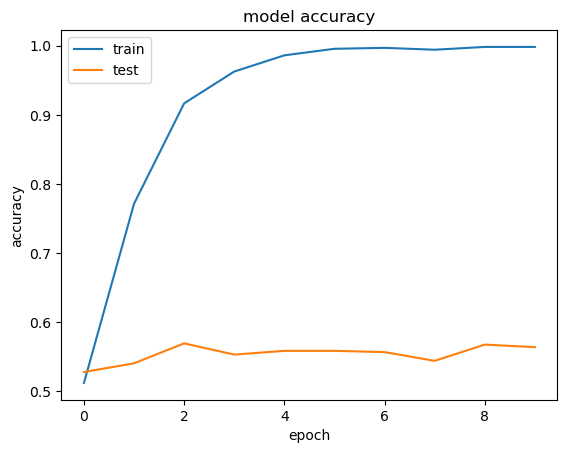

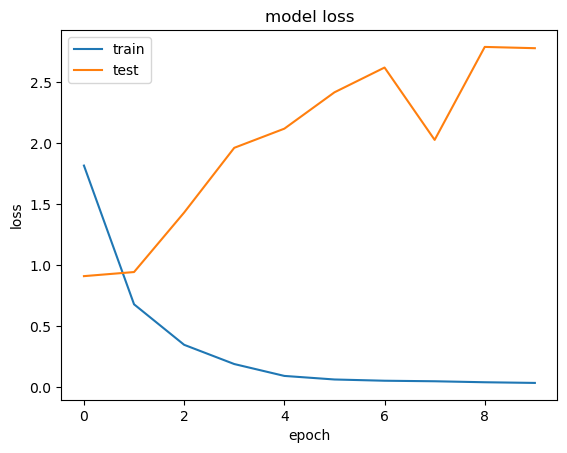

In [9]:
plot_history(history_rnn_simple)

In [10]:
y_pred=predict(model_rnn_simple)

93/93 [==============================] - 0s 3ms/step


In [11]:
# On importe les librairies pour l'évaluation
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

# On calcule la matrice de confusion
cm_test = confusion_matrix(y_test, y_pred)
print('La matrice de confusion sur le jeu de test :\n', cm_test, '\n')

# On calcul le score d accuracy
acc_train=accuracy_score(y_test, y_pred)
print('L accuracy sur le jeu de test est :\n', acc_train)


La matrice de confusion sur le jeu de test :
 [[ 221 1138]
 [ 160 1444]] 

L accuracy sur le jeu de test est :
 0.5619304758690516


Comments : 
- l'accuracy n'est pas tres tres bonne, on remarque sur la matrice de confusion que nos données test ne sont pas tres bien predit ( 143 + 1025 ) sur l'ensemble de test qui sont mal classé . 
- notre model overfitt rapidement, ce qui fait qu'on ne peux pas l'entrainer plus. 

Tous les RNN ont des boucles de rétroaction dans la couche récurrente. Cela leur permet de conserver des informations en « mémoire » au fil du temps. Mais, il peut être difficile de former des RNN standard pour résoudre des problèmes qui nécessitent l'apprentissage de dépendances temporelles à long terme. C'est parce que le gradient de la fonction de perte décroît de façon exponentielle avec le temps  (problème de fuite de gradient)

# RNN-LSTM gauche-droite classique 

In [12]:
embed_size = 128                                                   # dimension de l'embedding
RNN_size   = 64

# Example d'architecture pour le réseau RNN simple avec dropout
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, embed_size))                 # layer embedding
model_lstm.add(LSTM(RNN_size,return_sequences = False))          # layer lstm
#model_lstm.add(Dropout(0.25))                                    # layer Dropout
model_lstm.add(Dense(1))                                         # layer Dense

# On affiche l'architecture de notre modèle
model_lstm.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         640000    
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 689,473
Trainable params: 689,473
Non-trainable params: 0
_________________________________________________________________


In [13]:
# On entraine le réseau
batch_size = 32                                                             # tailles des mini-batch
epochs = 10                                                                 # nombre d'époques
history_lstm = model_lstm.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

Epoch 1/10
70/70 [==============================] - 3s 27ms/step - loss: 0.9610 - accuracy: 0.5550 - val_loss: 0.5815 - val_accuracy: 0.7171
Epoch 2/10
70/70 [==============================] - 2s 26ms/step - loss: 0.5087 - accuracy: 0.8233 - val_loss: 0.5622 - val_accuracy: 0.8306
Epoch 3/10
70/70 [==============================] - 2s 24ms/step - loss: 0.3122 - accuracy: 0.8972 - val_loss: 0.4976 - val_accuracy: 0.7369
Epoch 4/10
70/70 [==============================] - 2s 24ms/step - loss: 0.1773 - accuracy: 0.9500 - val_loss: 0.6564 - val_accuracy: 0.7910
Epoch 5/10
70/70 [==============================] - 2s 24ms/step - loss: 0.0927 - accuracy: 0.9802 - val_loss: 0.9240 - val_accuracy: 0.8288
Epoch 6/10
70/70 [==============================] - 2s 24ms/step - loss: 0.0632 - accuracy: 0.9937 - val_loss: 0.8238 - val_accuracy: 0.7964
Epoch 7/10
70/70 [==============================] - 2s 25ms/step - loss: 0.0546 - accuracy: 0.9964 - val_loss: 1.0944 - val_accuracy: 0.8288
Epoch 8/10
70

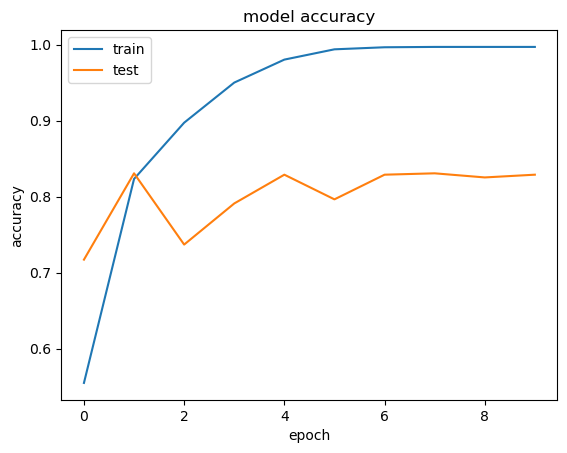

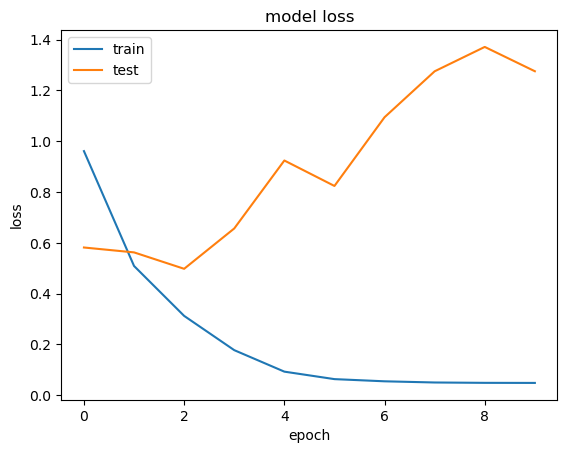

In [14]:
plot_history(history_lstm)

In [15]:
y_pred=predict(model_lstm)

93/93 [==============================] - 1s 7ms/step


In [16]:
# On importe les librairies pour l'évaluation
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

# On calcule la matrice de confusion
cm_test = confusion_matrix(y_test, y_pred)
print('La matrice de confusion sur le jeu de test :\n', cm_test, '\n')

# On calcul le score d accuracy
acc_train=accuracy_score(y_test, y_pred)
print('L accuracy sur le jeu de test est :\n', acc_train)

La matrice de confusion sur le jeu de test :
 [[ 799  560]
 [  82 1522]] 

L accuracy sur le jeu de test est :
 0.783327708403645


Comments :
-  On a une accuracy bien meilleur avec le LSTM


- Les réseaux LSTM sont un type de RNN qui utilise des unités spéciales en plus des unités standard. Les unités LSTM comprennent une « cellule mémoire » qui peut conserver des informations en mémoire pendant de longues périodes. Un ensemble de portes est utilisé pour contrôler quand les informations entrent dans la mémoire, quand elles sont sorties et quand elles sont oubliées. Cette architecture leur permet d'apprendre les dépendances à plus long terme. 

# LSTM bi-directionnel et return_sequences = False

In [17]:
embed_size = 128                                                   # dimension de l'embedding
RNN_size   = 64

# Example d'architecture pour le réseau RNN simple avec dropout
model_bidi = Sequential()
model_bidi.add(Embedding(num_words, embed_size))                 # layer embedding
model_bidi.add(Bidirectional(LSTM(RNN_size, return_sequences = False)))    # layer RNN
#model_bidi.add(Dropout(0.25))                                    # layer Dropout
model_bidi.add(Dense(1))                                         # layer Dense

# On affiche l'architecture de notre modèle
model_bidi.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model_bidi.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         640000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 738,945
Trainable params: 738,945
Non-trainable params: 0
_________________________________________________________________


In [18]:
# On entraine le réseau
batch_size = 32                                                            # tailles des mini-batch
epochs = 10                                                                 # nombre d'époques
history_bidi = model_bidi.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

Epoch 1/10
70/70 [==============================] - 5s 36ms/step - loss: 8.4983 - accuracy: 0.4491 - val_loss: 8.7547 - val_accuracy: 0.4324
Epoch 2/10
70/70 [==============================] - 2s 30ms/step - loss: 8.4983 - accuracy: 0.4491 - val_loss: 8.7547 - val_accuracy: 0.4324
Epoch 3/10
70/70 [==============================] - 2s 31ms/step - loss: 8.4983 - accuracy: 0.4491 - val_loss: 8.7547 - val_accuracy: 0.4324
Epoch 4/10
70/70 [==============================] - 2s 30ms/step - loss: 8.4983 - accuracy: 0.4491 - val_loss: 8.7547 - val_accuracy: 0.4324
Epoch 5/10
70/70 [==============================] - 2s 33ms/step - loss: 8.4983 - accuracy: 0.4491 - val_loss: 8.7547 - val_accuracy: 0.4324
Epoch 6/10
70/70 [==============================] - 3s 39ms/step - loss: 8.4983 - accuracy: 0.4491 - val_loss: 8.7547 - val_accuracy: 0.4324
Epoch 7/10
70/70 [==============================] - 2s 31ms/step - loss: 8.4983 - accuracy: 0.4491 - val_loss: 8.7547 - val_accuracy: 0.4324
Epoch 8/10
70

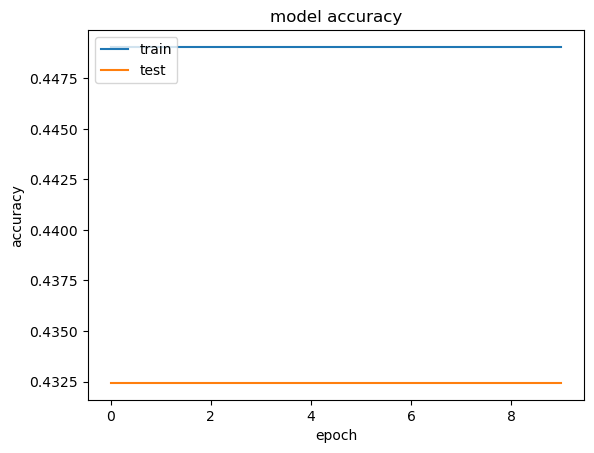

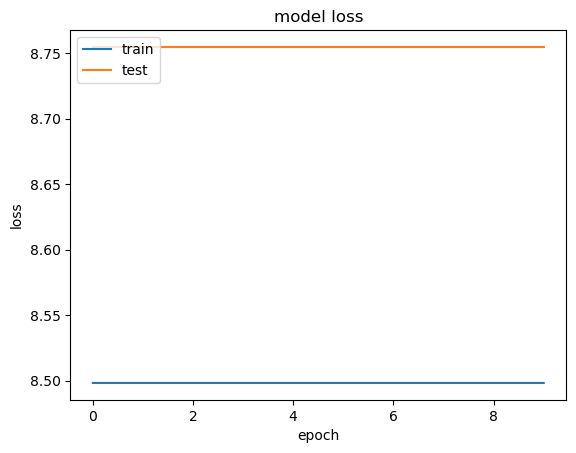

In [19]:
plot_history(history_bidi)

In [20]:
y_pred=predict(model_bidi)

93/93 [==============================] - 1s 9ms/step


In [21]:
# On importe les librairies pour l'évaluation
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

# On calcule la matrice de confusion
cm_test = confusion_matrix(y_test, y_pred)
print('La matrice de confusion sur le jeu de test :\n', cm_test, '\n')

# On calcul le score d accuracy
acc_train=accuracy_score(y_test, y_pred)
print('L accuracy sur le jeu de test est :\n', acc_train)

La matrice de confusion sur le jeu de test :
 [[1359    0]
 [1604    0]] 

L accuracy sur le jeu de test est :
 0.4586567667904151


L'accuracy est un peu plus meilleur que pour les LSTM bi

L'utilisation de la bidirectionnelle exécutera nos entrées de deux manières, l'une du passé au futur et l'autre du futur au passé. Ce qui fait la difference avec les LSTM normal qui sont capables à tout moment de préserver les informations du passé et du futur.



# Plusieurs couches LSTM.

In [22]:
embed_size = 64                                                 # dimension de l'embedding
RNN_size   = 64

model = Sequential()
model.add(Embedding(num_words, embed_size, mask_zero=True))   
model.add(Bidirectional(LSTM(RNN_size,return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))


model.summary()
# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model.compile(loss=BinaryCrossentropy(from_logits=True),
              optimizer=Adam(1e-4),
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          320000    
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [23]:
history = model.fit(x_train,y_train, epochs=10,
                    validation_data=(x_test,y_test),
                    validation_steps=30)

Epoch 1/10
87/87 [==============================] - 16s 96ms/step - loss: 0.6909 - accuracy: 0.4457 - val_loss: 0.6890 - val_accuracy: 0.4587
Epoch 2/10
87/87 [==============================] - 6s 68ms/step - loss: 0.6820 - accuracy: 0.4483 - val_loss: 0.6776 - val_accuracy: 0.4583
Epoch 3/10
87/87 [==============================] - 7s 79ms/step - loss: 0.5607 - accuracy: 0.6931 - val_loss: 0.5103 - val_accuracy: 0.7995
Epoch 4/10
87/87 [==============================] - 7s 78ms/step - loss: 0.3239 - accuracy: 0.8677 - val_loss: 0.4039 - val_accuracy: 0.8238
Epoch 5/10
87/87 [==============================] - 7s 79ms/step - loss: 0.2121 - accuracy: 0.9300 - val_loss: 0.4281 - val_accuracy: 0.8346
Epoch 6/10
87/87 [==============================] - 7s 81ms/step - loss: 0.1431 - accuracy: 0.9574 - val_loss: 0.4440 - val_accuracy: 0.8427
Epoch 7/10
87/87 [==============================] - 6s 74ms/step - loss: 0.1007 - accuracy: 0.9737 - val_loss: 0.4759 - val_accuracy: 0.8444
Epoch 8/10
8

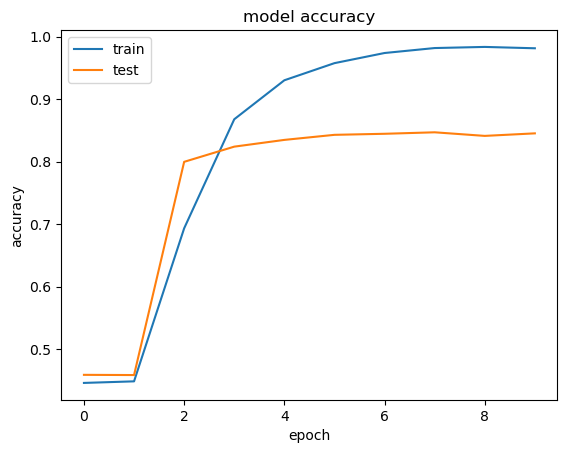

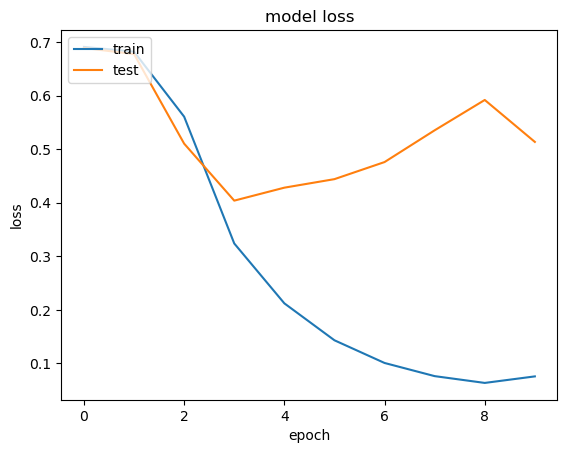

In [24]:
plot_history(history)

In [25]:
y_pred=predict(model)

93/93 [==============================] - 4s 16ms/step


In [26]:
# On importe les librairies pour l'évaluation
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

# On calcule la matrice de confusion
cm_test = confusion_matrix(y_test, y_pred)
print('La matrice de confusion sur le jeu de test :\n', cm_test, '\n')

# On calcul le score d accuracy
acc_train=accuracy_score(y_test, y_pred)
print('L accuracy sur le jeu de test est :\n', acc_train)

La matrice de confusion sur le jeu de test :
 [[1139  220]
 [ 237 1367]] 

L accuracy sur le jeu de test est :
 0.8457644279446507


# Conversion en texte

In [47]:
from tensorflow import keras

INDEX_FROM=3

word_to_id = keras.datasets.imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2
word_to_id["<UNUSED>"] = 3

id_to_word = {value:key for key,value in word_to_id.items()}


#Premier commentaire : 
print(' '.join(id_to_word[id] for id in x_train[0] ))




<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> begins better than it ends funny that the russian <UNK> crew <UNK> all other actors it's like those scenes where documentary shots br br spoiler part the message <UNK> was contrary to the whole story it just does not <UNK> br br


In [49]:
for i in range(10): 
    print(' '.join(id_to_word[id] for id in x_train[i] ))
    print(f'Note : {y_train[i]}')
    print('\n')

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> begins better than it ends funny that the russian <UNK> crew <UNK> all other actors it's like those scenes where documentary shots br br spoiler part the message <UNK> was contrary to the whole story it just does not <UNK> br br
Note : 0


<PAD> <START> when i rented this movie i had very low expectations but when i saw it i realized that the movie was less a lot less than what i expected the actors were bad the <UNK> wife was one of the worst the story was so stupid it could work for a disney movie except for the murders but this one is not a comedy it is a laughable masterpiece of stupidity the title is well chosen except for one thing they

In [46]:
[ (i , id_to_word[i]) for i in range(4,20)]

[(4, 'the'),
 (5, 'and'),
 (6, 'a'),
 (7, 'of'),
 (8, 'to'),
 (9, 'is'),
 (10, 'br'),
 (11, 'in'),
 (12, 'it'),
 (13, 'i'),
 (14, 'this'),
 (15, 'that'),
 (16, 'was'),
 (17, 'as'),
 (18, 'for'),
 (19, 'with')]